In [3]:
'''
MIT License

Copyright (c) 2016 Parvez Ahammad, Qingzhu (Clark) Gao, Prasenjit Dey

Permission is hereby granted, free of charge, to any person obtaining a copy
of this dataset, associated software, documentation files and analysis scripts (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
'''

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import show
from scipy.stats import chi2_contingency
import scipy.stats as scp
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

import io
from nbformat import current

def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("sp_analysis_helper.ipynb")

5444 Total sessions
2914 Complete sessions
2772 Valid sessions
142 Invalid sessions
2530 Incomplete
77482 Total votes
58212 Total valid votes


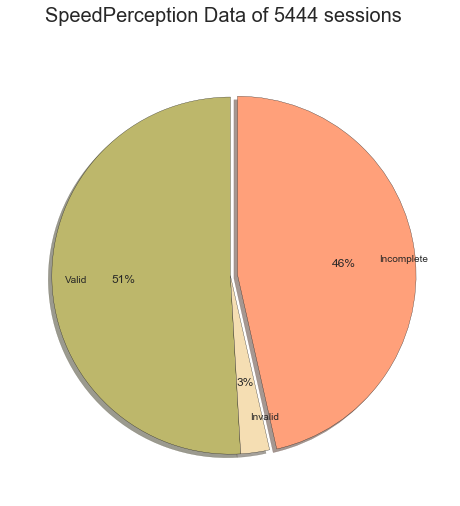

In [4]:
# Summary of the data, numbers of valid/complete/incomplete sessions
# Valid sessions are those who accurately labeld at least 4 out of 5 honeypot pairs

num_total_sessions = 5444
num_comlete_sessions = 2914
num_valid_sessions = 2772
num_invalid_sessions = num_comlete_sessions - num_valid_sessions
num_incomplete_sessions = 2530
total_vote = 77482
valid_vote = num_valid_sessions * 21

print '%d Total sessions'%num_total_sessions
print '%d Complete sessions'%num_comlete_sessions
print '%d Valid sessions'%num_valid_sessions
print '%d Invalid sessions'%(num_comlete_sessions - num_valid_sessions)
print '%d Incomplete'%num_incomplete_sessions
print '%d Total votes'%total_vote
print '%d Total valid votes'%(valid_vote)

# Pie Chart to show the above numbers
# plt.cm.prism
fig = plt.figure(figsize=(8,8))
fig.suptitle("SpeedPerception Data of %d sessions"%(num_comlete_sessions+num_incomplete_sessions), fontsize=20)

fig1 = plt.pie(
    [num_valid_sessions, num_invalid_sessions, num_incomplete_sessions],
    labels=['Valid', 'Invalid', 'Incomplete'],
    colors=['darkkhaki','#f5deb3', '#ffa07a',],
    startangle=90,
    shadow=True,
    explode=(0, 0,0.04),
    labeldistance= 0.8,
    autopct='%1.f%%'
)

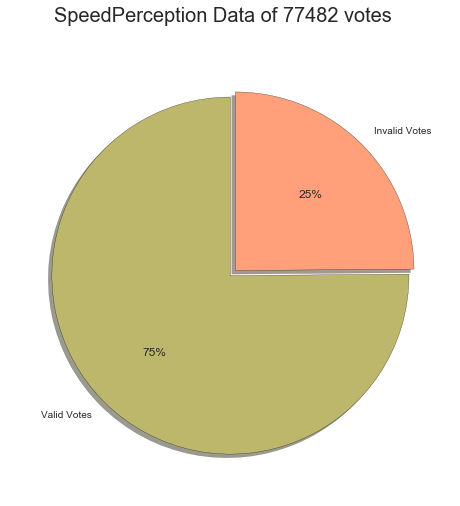

In [5]:
fig = plt.figure(figsize=(8,8))
fig.suptitle("SpeedPerception Data of %d votes"%(total_vote), fontsize=20)

# ax1 = plt.subplot2grid((4,3), (1,0), rowspan=3, colspan = 3)
fig1 = plt.pie(
    [valid_vote, total_vote-valid_vote],
    labels=['Valid Votes', 'Invalid Votes'],
    colors=['darkkhaki', '#ffa07a',],
    startangle=90,
    shadow=True,
    explode=(0, 0.04),
    labeldistance= 1.1,
    autopct='%1.f%%'
)

In [6]:
# Read valid session result data
df_valid = pd.read_csv('./data/sp_phase1_csv3.csv')
print 'There are %d valid votes'%(len(df_valid))
print 'There are %d valid sessions'%(len(df_valid)/16.)
df_valid.head(3)

There are 44352 valid votes
There are 2772 valid sessions


,sessionID,pairID,TimeToClick_InMS,userAgent,vote
0,58aPyrqJm6zGYK6eJ,5786da3020cfb49feadbbe6c,5643.0,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,left
1,58aPyrqJm6zGYK6eJ,5786da3020cfb49feadbbe6d,4561.0,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,right
2,58aPyrqJm6zGYK6eJ,5786da2f20cfb49feadbbe5a,5484.0,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,equal


 [],

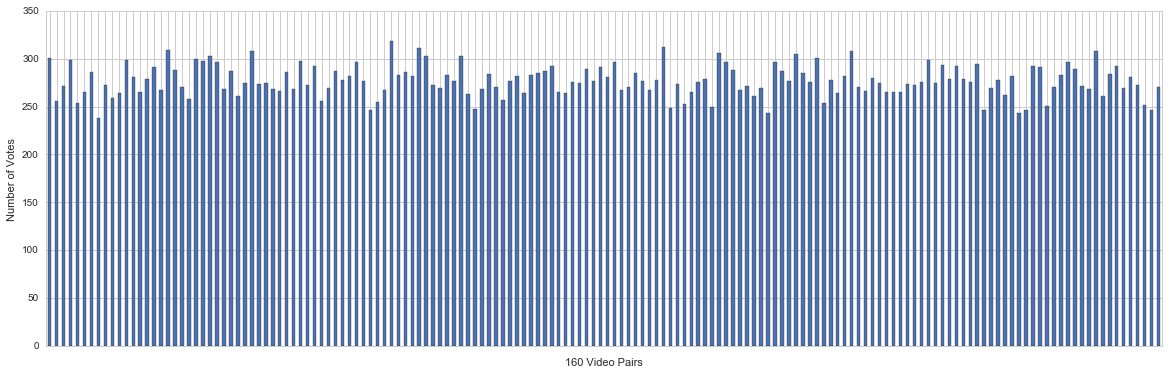

In [7]:
# Number of valid votes on each video pair
pair_count = df_valid.groupby(['pairID']).agg(['count'])
plt.figure(figsize=(20,6))
s = pd.Series(pair_count['vote']['count'].values)
g = s.plot(kind='bar' )
g.set(xticklabels=[], xlabel='160 Video Pairs', ylabel='Number of Votes')

In [8]:
# Compute majority vote for each pair
max_vote = {}
for i, id_ in enumerate(df_valid['pairID'].unique()):
    one_pair = df_valid.loc[df_valid['pairID']==id_]
    tmp = one_pair.groupby(['vote']).count()['sessionID']
    if len(tmp) < 3:
        for v in ['equal', 'left', 'right']:
            if not v in tmp.index.values:
                tmp.loc[v] = 0      
    count0, count1, count2 = tmp.ix['equal'], tmp.ix['left'], tmp.ix['right']
    new_l = sorted([(count1, 'pick1'), (count2, 'pick2'), (count0, 'pick0')], key=lambda x: x[0])
    max_vote[id_] = int(new_l[2][1][-1])
max_pick = []
for _id in df_valid['pairID'].ravel():
    max_pick.append(max_vote[_id])
df_valid['majority_pick'] = max_pick  
mapping = {'equal': 0, 'left': 1, 'right': 2}
df_valid = df_valid.replace({'vote': mapping})
df_valid.head(3)

,sessionID,pairID,TimeToClick_InMS,userAgent,vote,majority_pick
0,58aPyrqJm6zGYK6eJ,5786da3020cfb49feadbbe6c,5643.0,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,1,1
1,58aPyrqJm6zGYK6eJ,5786da3020cfb49feadbbe6d,4561.0,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,2,2
2,58aPyrqJm6zGYK6eJ,5786da2f20cfb49feadbbe5a,5484.0,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,0,2


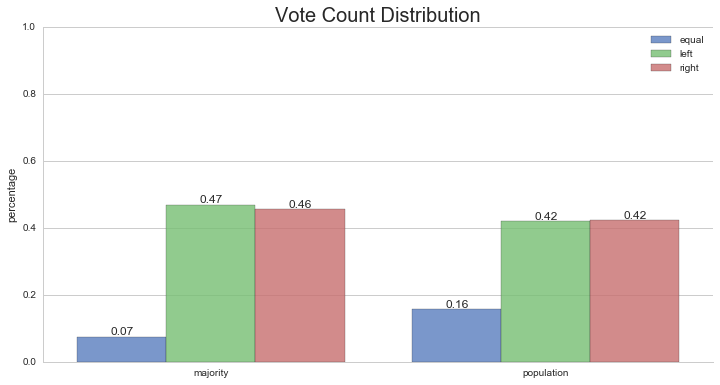

In [9]:
# Side by side bar plot showing the percentage of vote on equal/left/right of both majority and population
mVote_count = []
pVote_count = []
for i in range(3):
    mVote_count.append(max_vote.values().count(i)/float(len(max_vote)))
    pVote_count.append(df_valid['vote'].tolist().count(i)/float(len(df_valid)))
vote_count = pd.DataFrame({
        'vote_count': mVote_count + pVote_count,
        'vote': ['equal', 'left', 'right'] * 2,
        'type': ['majority'] * 3 + ['population'] * 3
    })

plt.figure(figsize=(12,6))
plt.title('Vote Count Distribution', size=20)
plt.gca()
ax = sns.barplot(x="type", y="vote_count", hue="vote", data=vote_count, palette="muted", alpha=0.8)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+0.1, height+0.005, '%1.2f'%(height))
ax.set(xlabel = '', ylabel='percentage', ylim=(0,1))
plt.legend(loc='best')
sns.despine(left=False, bottom=False)


In [10]:
df_perf = pd.read_csv('./data/sp_phase1_csv1.csv')
df_perf = df_perf[[
        '_TTFB',
        '_firstPaint',
        '_render',
#         '_domContentLoadedEventStart',
        '_domContentLoadedEventEnd',
        '_SpeedIndex',
        '_PSI',
        '_loadTime',
        '_lastVisualChange',
        '_visualComplete',
        'uid']]
df_pair = pd.read_csv('./data/sp_phase1_csv2.csv')
df_pair.head(3)

,pairID,uid_left,uid_right
0,5786da3020cfb49feadbbe6c,160605_JY_2PB,160605_X9_2DH
1,5786da3020cfb49feadbbe6d,160605_X9_2DH,160605_1W_2ZH
2,5786da2f20cfb49feadbbe5a,160605_TF_2MS,160605_HA_2PK


In [11]:
# merge performance metrics with user sessions
# map performance metrics to picks

for col in df_perf.columns.tolist()[:-1]:
    d = ([],[])
    for i in range(len(df_pair)):
        wpt1, wpt2 = df_pair['uid_left'][i], df_pair['uid_right'][i]
        d[0].append(df_perf[df_perf['uid']==wpt1][col].values[0])
        d[1].append(df_perf[df_perf['uid']==wpt2][col].values[0])
    df_pair[col[1:] + "_%d"%(1)] = d[0]
    df_pair[col[1:] + "_%d"%(2)] = d[1]
pair_perf = pd.merge(df_valid, df_pair, on=['pairID'])

d_diff = {}
pair_perf_m = pair_perf.iloc[:,range(8,26)]

for col in df_perf.columns.tolist()[:-1]:
    l1 = pair_perf_m[col[1:] + '_1'].ravel()
    l2 = pair_perf_m[col[1:] + '_2'].ravel()
    pick = pick_one(l1, l2)
    d_diff[col[1:] + "_pick"] = pick

perf_pick = pd.DataFrame(d_diff)
df_valid_perf = pd.concat([pair_perf[['pairID', 'vote', 'majority_pick']],perf_pick], axis=1)
df_pair.head(3)

,pairID,uid_left,uid_right,TTFB_1,TTFB_2,firstPaint_1,firstPaint_2,render_1,render_2,domContentLoadedEventEnd_1,...,SpeedIndex_1,SpeedIndex_2,PSI_1,PSI_2,loadTime_1,loadTime_2,lastVisualChange_1,lastVisualChange_2,visualComplete_1,visualComplete_2
0,5786da3020cfb49feadbbe6c,160605_JY_2PB,160605_X9_2DH,178,1338,1478,2782,1696,2896,2085,...,3419,4704,5067,4777,3924,7011,8396,7996,8400,8000
1,5786da3020cfb49feadbbe6d,160605_X9_2DH,160605_1W_2ZH,1338,280,2782,2191,2896,2296,3542,...,4704,3661,4777,4059,7011,3392,7996,13308,8000,8400
2,5786da2f20cfb49feadbbe5a,160605_TF_2MS,160605_HA_2PK,97,611,1976,1622,2096,1296,2533,...,3048,3178,3001,4200,3625,5026,8095,7996,8100,8000


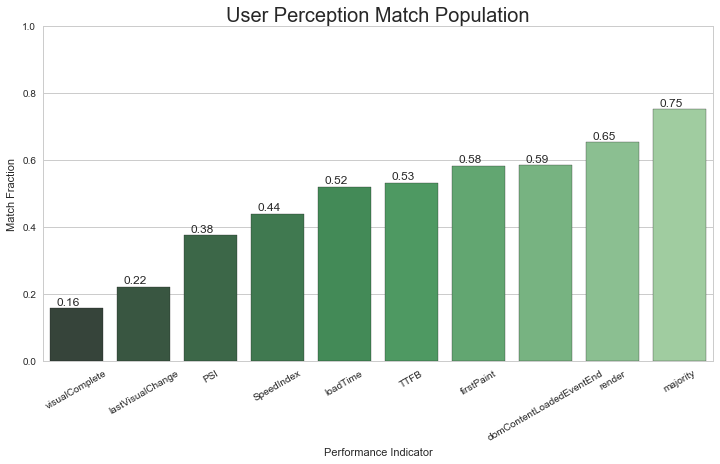

In [12]:
# Percentage match of each performance based pick to population pick
target1 = 'Population'
percentage_match(df_valid_perf, target1)

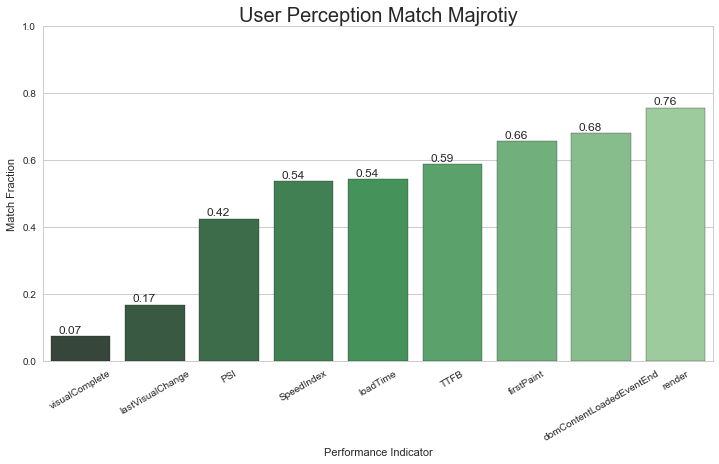

In [13]:
# Percentage match of each performance based pick to majority pick
unique_pair_perf = df_valid_perf.drop_duplicates(['pairID'], keep='first')
target2 = 'Majrotiy'
percentage_match(unique_pair_perf, target2)

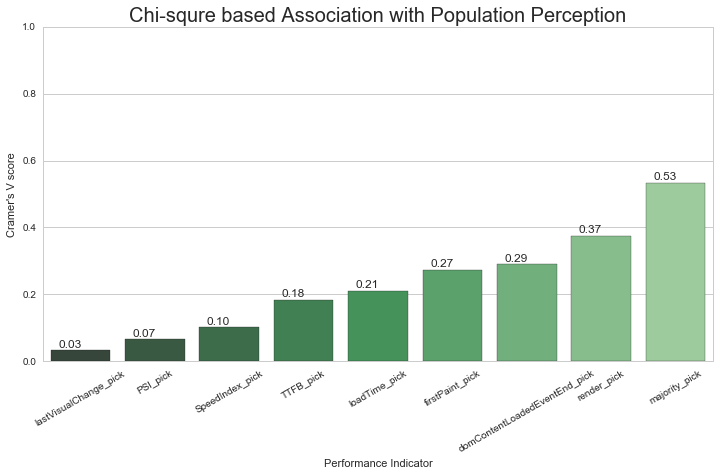

In [14]:
# # cramer's V
# association based on chi-square test statistics 
# WRT to population
d_cat = {}
for col in df_valid_perf.columns.tolist():
    d_cat[col] = map({0: 'euqal', 1: 'left', 2: 'right'}.get, df_valid_perf[col])
chiSquare_association(d_cat, target1)

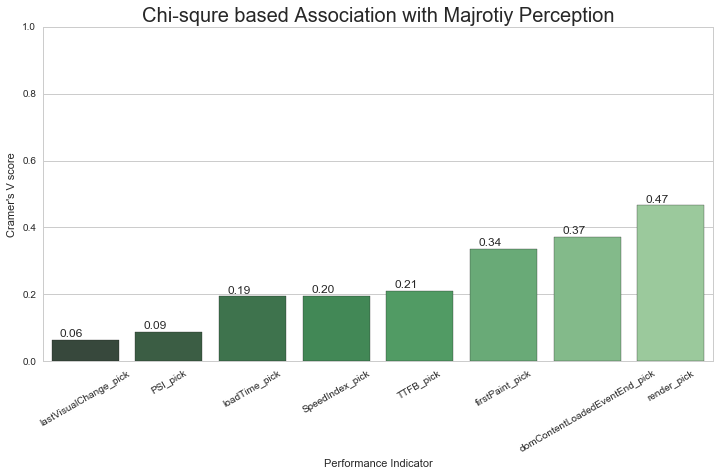

In [15]:
# WRT to majority
chiSquare_association(d_cat, target2)

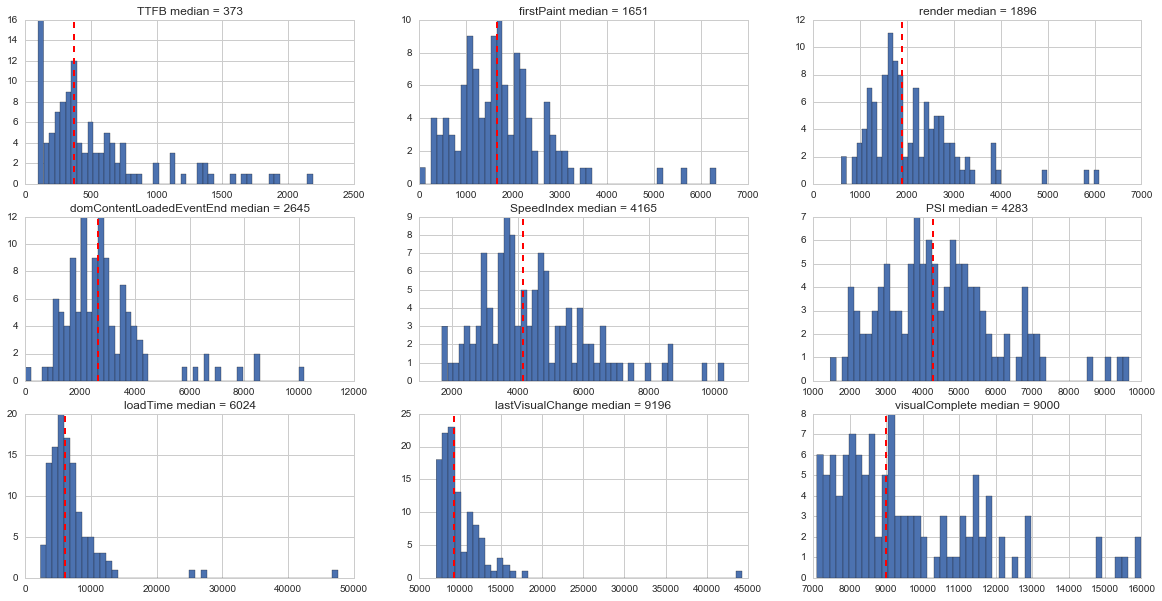

In [16]:
col_m = df_perf.columns.tolist()[:-1] 
cmap = plt.cm.prism
colors = cmap(np.linspace(0., 1., 2))
fig = plt.figure(figsize=(20, 10))

chart_count = 0
for metric in col_m:
    data = df_perf[metric]
    chart_count = chart_count + 1
    ax = fig.add_subplot(3, 3, chart_count)
    ax.set_title('%s median = %d'%(metric[1:], data.median()))
    ax.hist(data, bins = 50)
    ax.axvline(data.median(), color = 'red', linestyle = 'dashed', linewidth = 2)

[('TTFB', 373.0), ('firstPaint', 1651.0), ('render', 1896.0), ('domContentLoadedEventEnd', 2645.0), ('SpeedIndex', 4165.0), ('PSI', 4283.0), ('loadTime', 6024.0), ('visualComplete', 9000.0), ('lastVisualChange', 9196.0)]
************** Timing Analysis ****************


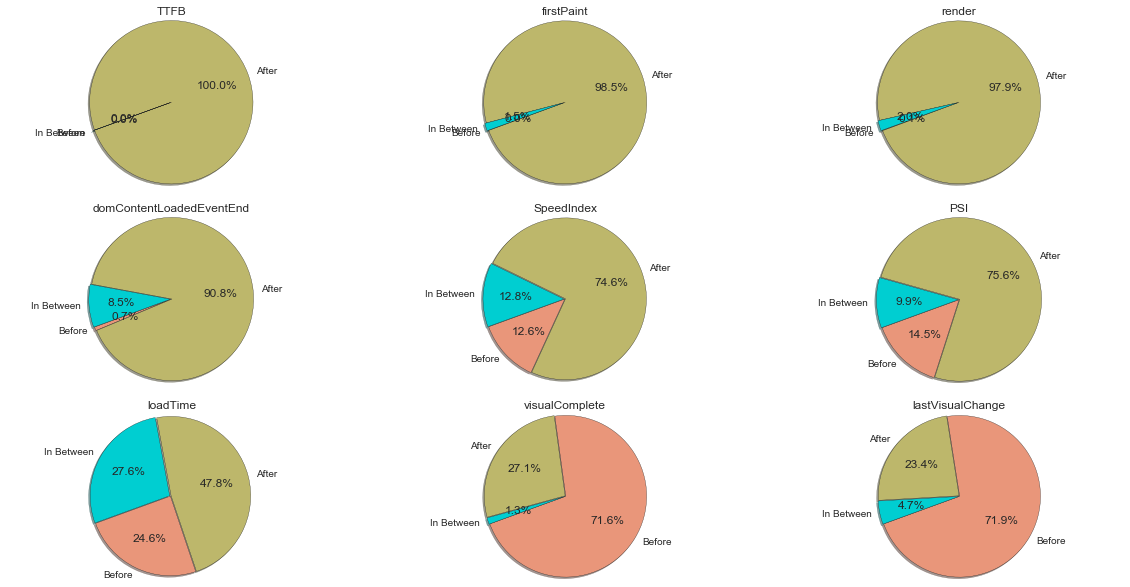

In [17]:
import operator

pair_perf_copy = pair_perf.copy()
GIF_DURATION_STRETCH_FACTOR = 1.09412199387
offset = 0

pair_perf_copy['TimeToClick_InMS'] = GIF_DURATION_STRETCH_FACTOR * pair_perf_copy['TimeToClick_InMS']
visual_metrics_median = {}
for metric in col_m:
    visual_metrics_median[metric[1:]] = df_perf[metric].median()
median_sorted_metrics = sorted(visual_metrics_median.items(), key = operator.itemgetter(1))
print median_sorted_metrics

sorted_visual_metrics = [i[0] for i in median_sorted_metrics]
print '************** Timing Analysis ****************'
### 3.1 : Count of votes made before/after/in-between the visual metrics of a pair
### Pie chart to show the timing numbers
cmap = plt.cm.prism
colors = cmap(np.linspace(0., 1., 2))
fig = plt.figure(figsize=(20, 10))
# fig.suptitle("SpeedPerception Response Timing Data of %d samples"%len(df_timing))
### Charts in the order of sorted visual metrics
chart_count = 0
before_both_metrics = []
after_both_metrics = []
in_between_metrics = []
for metric in sorted_visual_metrics:
    chart_count = chart_count + 1

    d_before_both_metrics = pair_perf_copy.loc[
            (pair_perf_copy['TimeToClick_InMS'] - offset < pair_perf_copy[metric + '_%d'%1])
            & 
            (pair_perf_copy['TimeToClick_InMS'] - offset< pair_perf_copy[metric + '_%d'%2])
        ]

    timings_before_both_metrics = d_before_both_metrics.count()[0]
#     print 'Number of tests with view duration less than both %s: %d'%(metric, timings_before_both_metrics)

    d_after_both_metrics = pair_perf_copy.loc[
            (pair_perf_copy['TimeToClick_InMS'] - offset> pair_perf_copy[metric + '_%d'%1])
            & 
            (pair_perf_copy['TimeToClick_InMS'] - offset> pair_perf_copy[metric + '_%d'%2])
        ]
    timings_after_both_metrics = d_after_both_metrics.count()[0]
#     print 'Number of tests with view duration greater than both %s: %d'%(metric, timings_after_both_metrics)

    timings_in_between_metrics = (len(pair_perf_copy) - timings_before_both_metrics - timings_after_both_metrics)
#     print 'Number of tests with duration lying in between both %s: %d'%(metric, timings_in_between_metrics)
#     print 
    
    before_both_metrics.append(timings_before_both_metrics/float(len(pair_perf_copy)))
    after_both_metrics.append(timings_after_both_metrics/float(len(pair_perf_copy)))
    in_between_metrics.append(timings_in_between_metrics/float(len(pair_perf_copy)))
    ax = fig.add_subplot(3,3, chart_count)
    ax.set_title(metric)
    ax.pie(
        [timings_before_both_metrics, timings_after_both_metrics, timings_in_between_metrics],
        labels= ['Before', 'After', 'In Between'],
        colors= ['darksalmon', 'darkkhaki', 'darkturquoise'],
        startangle= 200,
        shadow=True,
        explode=(0, 0.01, 0.01),
        autopct='%1.1f%%',
        labeldistance= 1.1
    )

    ax.axis('equal')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

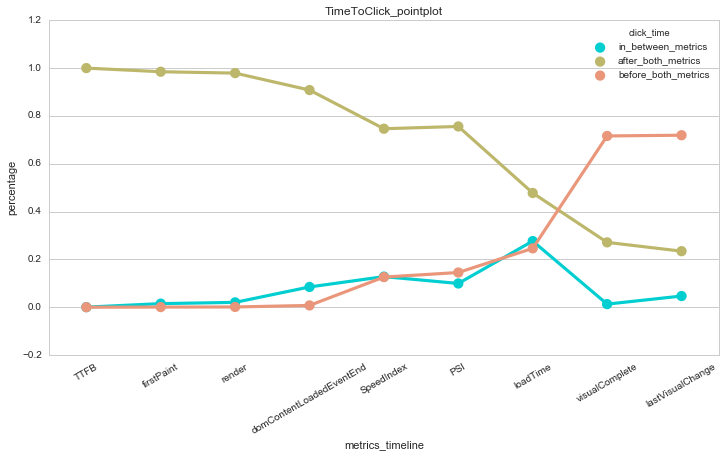

In [18]:
fig = plt.figure(figsize=(12, 6))
total_metrics = [1]*len(sorted_visual_metrics)
ttd_timeline = {
    'percentage': in_between_metrics+after_both_metrics+before_both_metrics,
    'click_time': ['in_between_metrics']*len(sorted_visual_metrics) +
    ['after_both_metrics']*len(sorted_visual_metrics) + ['before_both_metrics']*len(sorted_visual_metrics),
    'metrics_timeline': sorted_visual_metrics * 3
               }
# pd.DataFrame(ttd_timeline).plot(kind='barh', stacked=True)
ttd_df = pd.DataFrame(ttd_timeline)
sns.pointplot(x='metrics_timeline', y='percentage',hue='click_time', data= ttd_df,
             palette={'in_between_metrics':'darkturquoise', 
                     'after_both_metrics':'darkkhaki',
                     'before_both_metrics':'darksalmon'})
plt.ylabel('percentage')
plt.title('TimeToClick_pointplot')
plt.xticks(rotation=30)